In [1]:
__author__ = 'racah'
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from nbfinder import NotebookFinder
import sys
import os
sys.meta_path.append(NotebookFinder())
%matplotlib inline

In [2]:
def load_data(
    bg_cfg_file = './config/BgFileListAug16.txt',
    sig_cfg_file='./config/SignalFileListAug16.txt',
    group_name='CollectionTree',
    branches=['CaloCalTopoClustersAuxDyn.calPhi', 'CaloCalTopoClustersAuxDyn.calEta','CaloCalTopoClustersAuxDyn.calE'],
    num_events=1000,
    preprocess=True,
    bin_size=0.025,
    eta_range = [-5,5],
    phi_range = [-3.14, 3.14],
    num_files=None,
    dataset_name='histo', 
    type='root'):
  
    assert num_events % 2 == 0, "why an odd number for num_events?!, even please"
    num_each = num_events / 2
    bg_path = [line.rstrip() for line in open(bg_cfg_file)]
    sig_path = [line.rstrip() for line in open(sig_cfg_file)]
    if type == 'hdf':
        bgdf = pd.read_hdf(bg_path, group_name)
        sigdf = pd.read_hdf(sig_path, group_name)
        x_bg = bgdf[dataset_name][:num_each]
        x_sig = sigdf[dataset_name][:num_each]
        #background first
        x_concat = np.hstack((x_bg, x_sig))
        dim_x, dim_y = x_bg[0].shape
        x = np.zeros((num_events ,dim_x, dim_y ))
        for i in range(num_events):
            x[i] = x_concat[i]
        # add a channel size of 1 as a place holder
        x = np.expand_dims(x,axis=1)
        
    if type == 'root':
        sys.path.append('/global/homes/w/wbhimji/cori-envs/nersc-rootpy/lib/python2.7/site-packages/')
        import ROOT
        import rootpy
        import root_numpy as rnp
        if num_files is not None:
            assert num_files > 1, "everything works better if num_files is more than one"
                
            bgarray = rnp.root2array(bg_path[:num_files], treename=group_name,branches=branches, start=0, stop=num_each,warn_missing_tree=True)
            sigarray = rnp.root2array(sig_path[:num_files], treename=group_name, branches=branches, start=0, stop=num_each,warn_missing_tree=True)

        else: 
            bgarray = rnp.root2array(bg_path, treename=group_name,branches=branches, start=0, stop=num_each,warn_missing_tree=True)
            sigarray = rnp.root2array(sig_path, treename=group_name, branches=branches, start=0, stop=num_each,warn_missing_tree=True)
        
        
        
        bgdf = pd.DataFrame.from_records(bgarray)

        sigdf = pd.DataFrame.from_records(sigarray)
        
        phi_bins = int(np.floor((phi_range[1] - phi_range[0]) / bin_size))
        eta_bins = int(np.floor((eta_range[1] - eta_range[0]) / bin_size))
        
        
        x_bg = np.zeros((num_each,1,phi_bins, eta_bins ))
        x_sig = np.zeros((num_each,1,phi_bins, eta_bins ))
        
        #num events is now num each
        for i in range(num_each):
            phi, eta, E =  bgdf['CaloCalTopoClustersAuxDyn.calPhi'][i],bgdf['CaloCalTopoClustersAuxDyn.calEta'][i],\
                bgdf['CaloCalTopoClustersAuxDyn.calE'][i]
            x_bg[i] = np.histogram2d(phi,eta, bins=(phi_bins, eta_bins), weights=E, range=[phi_range,eta_range])[0]
            phi, eta, E =  sigdf['CaloCalTopoClustersAuxDyn.calPhi'][i],sigdf['CaloCalTopoClustersAuxDyn.calEta'][i],\
                sigdf['CaloCalTopoClustersAuxDyn.calE'][i]
            x_sig[i] = np.histogram2d(phi,eta, bins=(phi_bins, eta_bins), weights=E, range=[phi_range,eta_range])[0]

        #background first
        x = np.vstack((x_bg, x_sig))      
    
        # 1 means signal, 0 means background
        y = np.zeros((num_events,)).astype('int32')
        #make the last half signal label
        y[num_each:] = 1


        #shuffle examples
        rng = np.random.RandomState(seed=9)

        inds = np.arange(num_events)

        rng.shuffle(inds)

        #split train, val, test
        tr_inds = inds[:int(0.6*num_events)] 
        val_inds = inds[int(0.6*num_events):int(0.8*num_events)]
        te_inds = inds[int(0.8*num_events):]

        x_tr, y_tr, x_val, y_val, x_te, y_te = x[tr_inds], y[tr_inds], \
                                               x[val_inds], y[val_inds], \
                                               x[te_inds], y[te_inds]
        if preprocess:
            '''a type of sparse preprocessing, which scales everything between -1 and 1 without losing sparsity'''
            #only calculate the statistic using training set
            max_abs=np.abs(x_tr).max(axis=(0,1,2,3))

            #then scale all sets
            x_tr /= max_abs
            x_te /= max_abs
            x_val /= max_abs
    
        
 
    
        return x_tr, y_tr, x_val, y_val, x_te, y_te
    

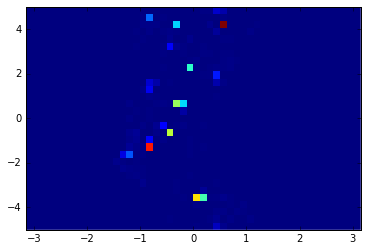


tab completion not implemented for this context

tab completion not implemented for this context


In [22]:
if __name__=="__main__":
    data = load_data(type='root', num_events=50, num_files=2, preprocess=False, bin_size=0.2,    bg_cfg_file = '../config/BgFileListAug16.txt',
    sig_cfg_file='../config/SignalFileListAug16.txt')
    x,y,xv,yv,x_te,y_te = data
    plt.imshow(x[11][0],extent=[-3.15, 3.15, -5, 5], interpolation='none',aspect='auto', origin='low')


In [26]:
6.28 / 0.2

31.4

In [24]:
a = np.histogram2d?


variable "np" not defined.

variable "np.his" not defined.


In [ ]:
a = np.histogram2d

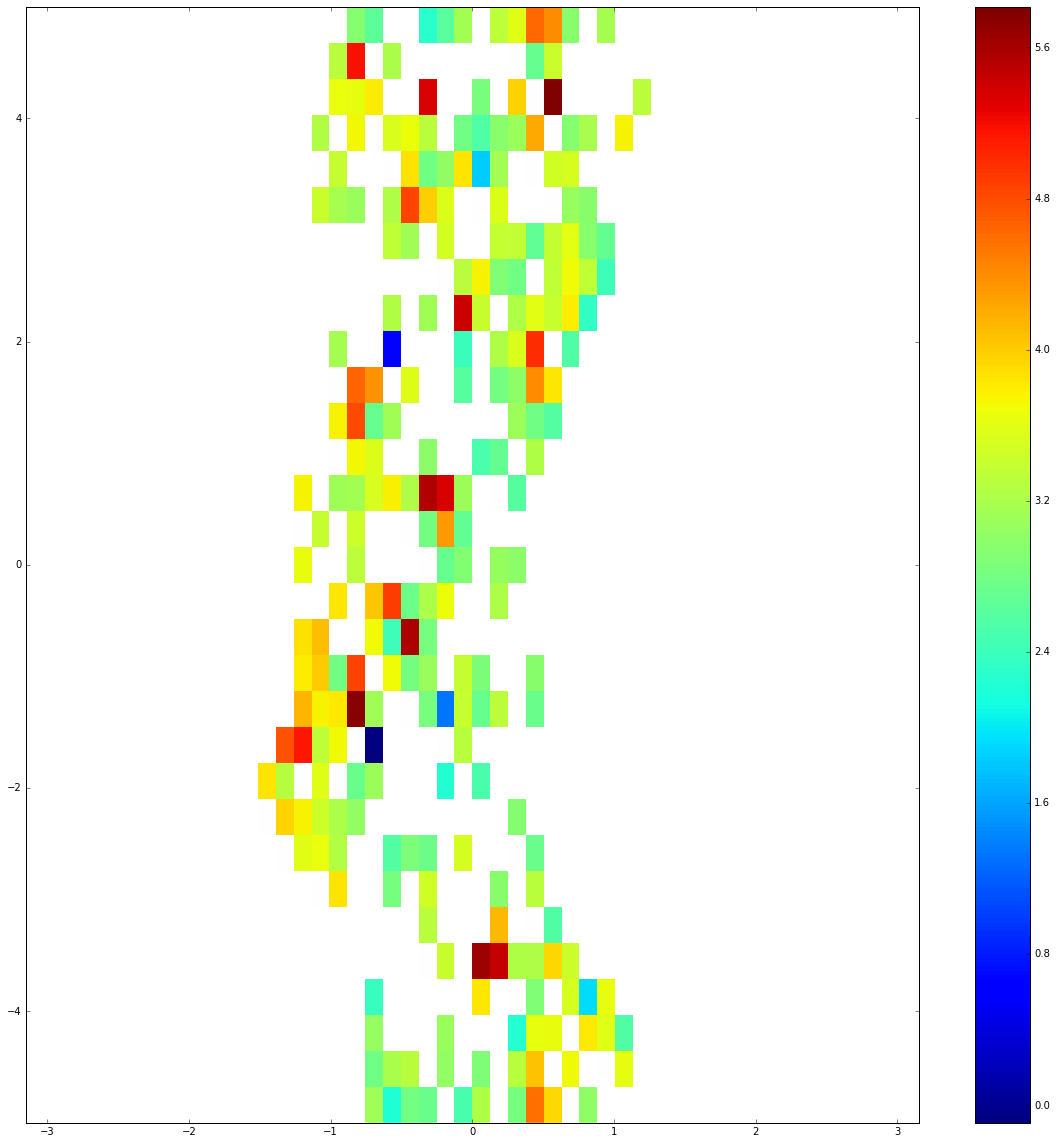

In [23]:
plt.figure(figsize=(20,20))
plt.imshow(np.log10(x[y==1.][5][0]),extent=[-3.15, 3.15, -5, 5], interpolation='none',aspect='auto', origin='low')
#plt.xlabel('')
plt.colorbar()